In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
# System libraries
from pathlib import Path
import os.path

In [4]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-08 16:12:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.3'

     0K ..........                                            100%  159K=0,06s

2023-06-08 16:12:36 (159 KB/s) - 'helper_functions.py.3' saved [10246/10246]



In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [7]:
# Walk through each directory
dataset = "C:/Users/Asus/Downloads/Dataset"
walk_through_dir(dataset)

There are 6 directories and 0 images in 'C:/Users/Asus/Downloads/Dataset'.
There are 0 directories and 494 images in 'C:/Users/Asus/Downloads/Dataset\BotolPlastik'.
There are 0 directories and 523 images in 'C:/Users/Asus/Downloads/Dataset\Ember'.
There are 0 directories and 473 images in 'C:/Users/Asus/Downloads/Dataset\Gelas'.
There are 0 directories and 486 images in 'C:/Users/Asus/Downloads/Dataset\Jerigen'.
There are 0 directories and 502 images in 'C:/Users/Asus/Downloads/Dataset\Karung'.
There are 0 directories and 500 images in 'C:/Users/Asus/Downloads/Dataset\Kresek'.


In [8]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [9]:
print(labels)

0       BotolPlastik
1       BotolPlastik
2       BotolPlastik
3       BotolPlastik
4       BotolPlastik
            ...     
2972          Kresek
2973          Kresek
2974          Kresek
2975          Kresek
2976          Kresek
Name: Label, Length: 2977, dtype: object


In [10]:
image_df

,Filepath,Label
0,C:\Users\Asus\Downloads\Dataset\BotolPlastik\0...,BotolPlastik
1,C:\Users\Asus\Downloads\Dataset\BotolPlastik\0...,BotolPlastik
2,C:\Users\Asus\Downloads\Dataset\BotolPlastik\0...,BotolPlastik
3,C:\Users\Asus\Downloads\Dataset\BotolPlastik\0...,BotolPlastik
4,C:\Users\Asus\Downloads\Dataset\BotolPlastik\0...,BotolPlastik
...,...,...
2972,C:\Users\Asus\Downloads\Dataset\Kresek\0000449...,Kresek
2973,C:\Users\Asus\Downloads\Dataset\Kresek\0000449...,Kresek
2974,C:\Users\Asus\Downloads\Dataset\Kresek\0000449...,Kresek
2975,C:\Users\Asus\Downloads\Dataset\Kresek\0000449...,Kresek


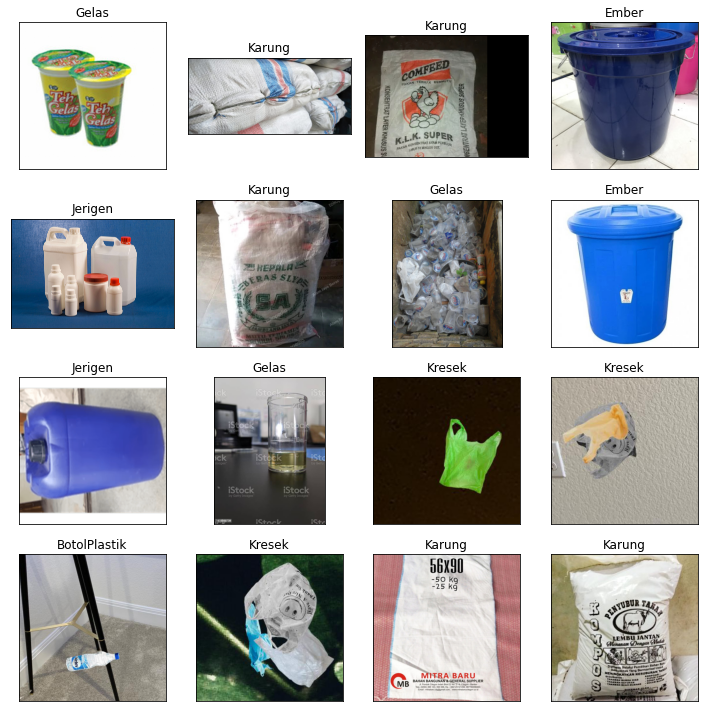

In [11]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [12]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1905 validated image filenames belonging to 6 classes.
Found 476 validated image filenames belonging to 6 classes.
Found 596 validated image filenames belonging to 6 classes.


In [15]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [17]:
# Create checkpoint callback
checkpoint_path = "bottles_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [19]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)



outputs = Dense(6, activation='softmax')(x)  # Adjust to the correct number of classes


model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "bottle_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bottle_classification/20230608-161241
Epoch 1/100
15/60 [======>.......................] - ETA: 42s - loss: 1.9249 - accuracy: 0.1886

C:\Users\Asus\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


60/60 [==============================] - 82s 1s/step - loss: 1.5077 - accuracy: 0.4376 - val_loss: 0.4551 - val_accuracy: 0.9223
Epoch 2/100
60/60 [==============================] - 74s 1s/step - loss: 0.4182 - accuracy: 0.9102 - val_loss: 0.2004 - val_accuracy: 0.9580
Epoch 3/100
60/60 [==============================] - 81s 1s/step - loss: 0.2198 - accuracy: 0.9413 - val_loss: 0.1495 - val_accuracy: 0.9643
Epoch 4/100
60/60 [==============================] - 70s 1s/step - loss: 0.1486 - accuracy: 0.9547 - val_loss: 0.1102 - val_accuracy: 0.9727
Epoch 5/100
60/60 [==============================] - 70s 1s/step - loss: 0.1037 - accuracy: 0.9714 - val_loss: 0.0940 - val_accuracy: 0.9748
Epoch 6/100
60/60 [==============================] - 71s 1s/step - loss: 0.0742 - accuracy: 0.9838 - val_loss: 0.0825 - val_accuracy: 0.9748
Epoch 7/100
60/60 [==============================] - 70s 1s/step - loss: 0.0608 - accuracy: 0.9872 - val_loss: 0.0750 - val_accuracy: 0.9790
Epoch 8/100
60/60 [======

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.04819
Test Accuracy: 98.49%


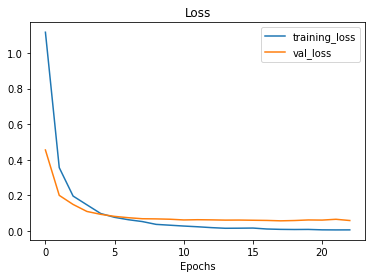

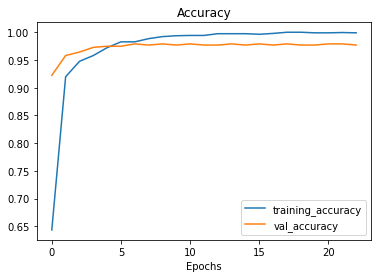

In [22]:
plot_loss_curves(history)

In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Karung', 'Kresek', 'Jerigen', 'Gelas', 'Ember']


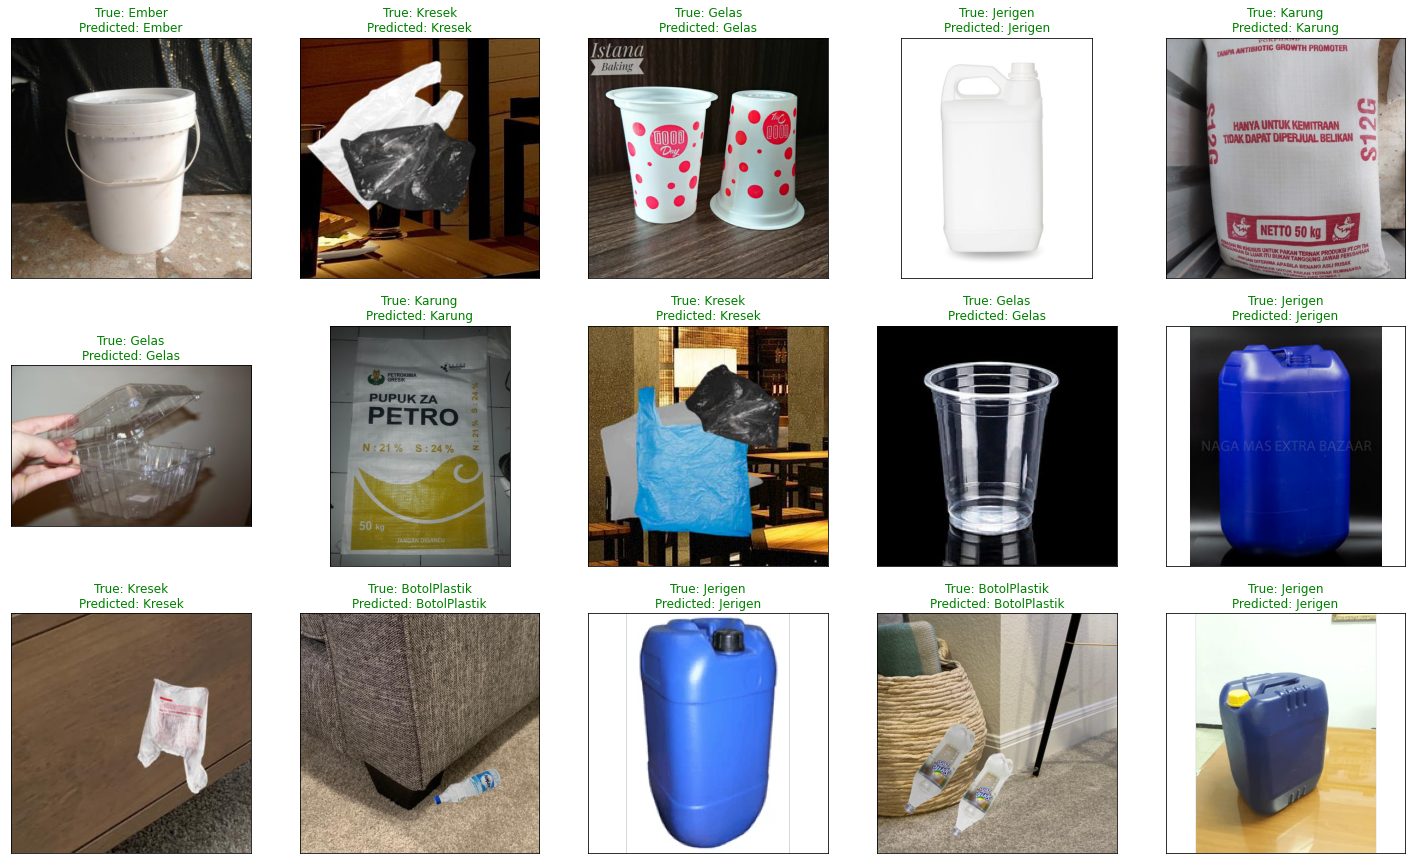

<Figure size 432x288 with 0 Axes>

In [24]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [25]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

BotolPlastik       0.99      1.00      1.00       115
       Ember       1.00      0.95      0.97       100
       Gelas       0.95      0.96      0.96       101
     Jerigen       1.00      1.00      1.00        86
      Karung       0.99      1.00      0.99        93
      Kresek       0.98      1.00      0.99       101

    accuracy                           0.98       596
   macro avg       0.99      0.99      0.99       596
weighted avg       0.99      0.98      0.98       596



In [26]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
BotolPlastik,0.991379,1.000000,0.995671,115.000000
Ember,1.000000,0.950000,0.974359,100.000000
Gelas,0.950980,0.960396,0.955665,101.000000
Jerigen,1.000000,1.000000,1.000000,86.000000
Karung,0.989362,1.000000,0.994652,93.000000
Kresek,0.980583,1.000000,0.990196,101.000000
accuracy,0.984899,0.984899,0.984899,0.984899
macro avg,0.985384,0.985066,0.985091,596.000000
weighted avg,0.985079,0.984899,0.984854,596.000000


In [27]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

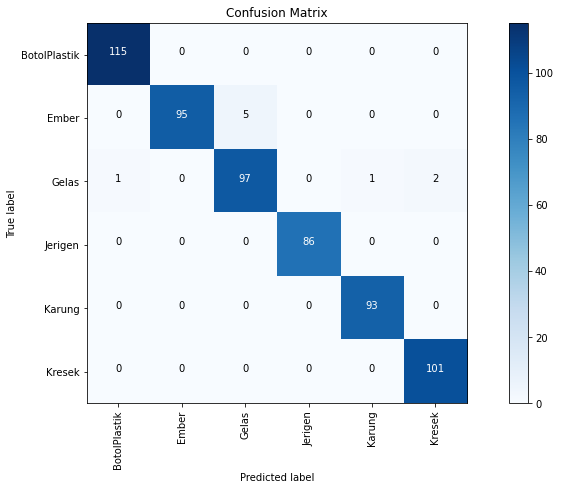

In [28]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [29]:
#Predict by file location
from tensorflow.keras.preprocessing import image
img_path = "C:/Users/Asus/Downloads/Dataset/Gelas/sap_plastic_cup_pp_gelas_plastik_-14_oz-50_pcs-_full01_fm7kni5b.png"
img = image.load_img(img_path, target_size=(224, 224))  # Adjust the target size as per your model's input size
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the pixel values (if required)

In [30]:
preds = model.predict(x)

In [31]:
predicted_class = np.argmax(preds, axis=1)

# Load the class labels
class_labels = ['BotolPlastik','Ember','Gelas','Jerigen','Karung','Kresek']  # Replace with your actual class labels

# Get the predicted class label
predicted_label = class_labels[predicted_class[0]]

# Print the predicted class label or perform further processing
print("Predicted class:", predicted_label)


Predicted class: Gelas


In [ ]:
#TIDAK BISA MENGGUNAKAN BUTTON UPLOAD

In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import ipywidgets as widgets
from IPython.display import display

In [54]:
# Load your pre-trained CNN model
class_labels = ['BotolPlastik','Ember','Gelas','Jerigen','Karung','Kresek'] # Replace with your actual class labels
upload_widget = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
# Function to preprocess the uploaded image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Function to handle the file upload and perform prediction
def handle_upload(change):
    uploaded_file = upload_widget.value[0]
    image_path = uploaded_file['name']
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_class]
    print("Predicted class:", predicted_label)


# Call the handle_upload function when the file upload button is clicked
upload_widget.observe(handle_upload, names='value')

# Display the file upload button
display(upload_widget)


FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Upload')

In [52]:
# Create a file upload button



upload_widget

FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Upload')

In [53]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/--\|/-\|/-\|/-\-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)
